In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.python.keras as krs
from keras.layers import LSTM, Dropout, Dense
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler


2022-11-07 08:01:51.389595: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-07 08:01:51.890239: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-07 08:01:51.890259: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-07 08:01:51.964346: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-07 08:01:53.224848: W tensorflow/stream_executor/platform/de

In [2]:
_df = pd.read_csv("../Data/wig20_d.csv")
# df = pd.read_csv("../Data/mwig40_d.csv")
# df = pd.read_csv("../Data/swig80_d.csv")

_df.drop(range(1000), inplace=True)
_df.reset_index(inplace=True, drop=True)
_df.head()

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen
0,1997-02-06,1717.2,1779.8,1717.2,1779.8,4435886.0
1,1997-02-07,1778.2,1808.7,1778.2,1799.0,5448243.0
2,1997-02-10,1797.4,1797.4,1780.3,1783.3,6513315.0
3,1997-02-11,1803.3,1832.2,1803.3,1832.0,5146340.0
4,1997-02-12,1824.6,1824.6,1804.9,1810.2,5748398.0


In [3]:
_df.head()

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen
0,1997-02-06,1717.2,1779.8,1717.2,1779.8,4435886.0
1,1997-02-07,1778.2,1808.7,1778.2,1799.0,5448243.0
2,1997-02-10,1797.4,1797.4,1780.3,1783.3,6513315.0
3,1997-02-11,1803.3,1832.2,1803.3,1832.0,5146340.0
4,1997-02-12,1824.6,1824.6,1804.9,1810.2,5748398.0


In [4]:
_data_len = len(_df.index)
_train_set_ratio, _test_set_ratio, _validation_set_ratio = .8, .1, .1
scaler = MinMaxScaler(feature_range=(0,1))

_train_set_len = int(_data_len * _train_set_ratio)
_test_set_len = int(_data_len * _test_set_ratio)
_validation_set_len = int(_data_len * _validation_set_ratio)

_train_set_end = _train_set_len
_test_set_end = _train_set_end + _test_set_len
_validation_set_end = _test_set_end + _validation_set_len


colnames = _df.columns.to_numpy()
col_len = 5

_data = _df.to_numpy()[:, 1:col_len]
#_data = _data.flatten().reshape((-1, 1))
#_data = _df.to_numpy().transpose()[1:5, :]
_data = scaler.fit_transform(_data)


#train_set, test_set, validation_set = _df.iloc[:_train_set_end, :], _df.iloc[_train_set_end:_test_set_end, :], _df.iloc[_test_set_end:_validation_set_end, :]
train_set, test_set, validation_set = _data[:_train_set_end, :], _data[_train_set_end:_test_set_end, :], _data[_test_set_end:_validation_set_end, :]


In [5]:
colnames

array(['Data', 'Otwarcie', 'Najwyzszy', 'Najnizszy', 'Zamkniecie',
       'Wolumen'], dtype=object)

In [6]:
train_set[:, :10]

array([[0.24675461, 0.26440479, 0.25373683, 0.27438683],
       [0.26746804, 0.27424346, 0.27448753, 0.28090288],
       [0.27398767, 0.27039651, 0.27520189, 0.27557465],
       ...,
       [0.46054432, 0.46188283, 0.46512182, 0.47124962],
       [0.46464965, 0.46812306, 0.46929237, 0.47715819],
       [0.47197745, 0.47321261, 0.47799065, 0.48053839]])

In [7]:
test_set[:, :10]

array([[0.47437138, 0.4740535 , 0.47738854, 0.48183481],
       [0.47701319, 0.49488832, 0.48440976, 0.50396563],
       [0.50061631, 0.50333459, 0.50617078, 0.5092158 ],
       ...,
       [0.14132328, 0.15874297, 0.14135308, 0.16905419],
       [0.17372791, 0.18540269, 0.17190764, 0.17549897],
       [0.15983293, 0.15687056, 0.14607472, 0.14734081]])

In [8]:
validation_set[:, :10]

array([[0.15579891, 0.15996514, 0.15404503, 0.16280625],
       [0.16884158, 0.1711213 , 0.15033031, 0.15968737],
       [0.14975127, 0.16672284, 0.14954451, 0.17671734],
       ...,
       [0.14393793, 0.14202745, 0.14544539, 0.14725936],
       [0.13913649, 0.13520506, 0.13880857, 0.13853056],
       [0.13145894, 0.13714216, 0.1324643 , 0.1393281 ]])

In [9]:
train_set.shape

(5143, 4)

In [10]:
def batches_create(data_array: np.array):
    _x_train = np.array([data_array[i:i+60, :].astype("float32") for i in range(data_array.shape[0]-60-1)])
    _y_train = np.array([data_array[i+60, :].astype("float32") for i in range(data_array.shape[0]-60-1)])
    print(_x_train.shape)
    print(_y_train.shape)
    #_x_train, _y_train = np.reshape(_x_train, (_x_train.shape[0], _x_train.shape[1], 1)), _y_train
    return _x_train, _y_train


In [11]:
def _y_convert_to_base(_y, _y_col_num=None, _scaler=None):
    _y = _scaler.inverse_transform(_y) if _scaler is not None else _y
    _y = _y[:, _y_col_num] if _y_col_num is not None else _y
    return _y


def results_plot(_y, _prediction, _y_col_num=None, _prediction_col_num=None, _scaler=None):
    _y = _y_convert_to_base(_y, _y_col_num, _scaler)
    _prediction = _y_convert_to_base(_prediction, _prediction_col_num, _scaler)
    _x = range(len(_y))

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(_x, _y, label="rzeczywiste")
    ax.plot(_x, _prediction, label="predykcja")
    fig.legend()
    return fig


def results_histogram(_y, _prediction, _y_col_num=None, _prediction_col_num=None, _scaler=None, _bins=50):
    _y = _y_convert_to_base(_y, _y_col_num, _scaler)
    _prediction = _y_convert_to_base(_prediction, _prediction_col_num, _scaler)
    deltas = _prediction - _y

    fig, ax = plt.subplots()
    ax.hist(deltas, bins=_bins)
    return fig


In [12]:
X_train, y_train = batches_create(train_set)
X_test, y_test = batches_create(test_set)
X_validation, y_validation = batches_create(validation_set)


(5082, 60, 4)
(5082, 4)
(581, 60, 4)
(581, 4)
(581, 60, 4)
(581, 4)


In [13]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=y_train.shape[1]))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=60, batch_size=32)

Epoch 1/60


2022-11-07 08:01:54.830797: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-07 08:01:54.831224: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-07 08:01:54.831265: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (banjaro): /proc/driver/nvidia/version does not exist
2022-11-07 08:01:54.832089: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


159/159 [==============================] - 22s 96ms/step - loss: 0.0105
Epoch 2/60
159/159 [==============================] - 14s 90ms/step - loss: 0.0040
Epoch 3/60
159/159 [==============================] - 14s 86ms/step - loss: 0.0033
Epoch 4/60
159/159 [==============================] - 14s 85ms/step - loss: 0.0029
Epoch 5/60
159/159 [==============================] - 14s 86ms/step - loss: 0.0023
Epoch 6/60
159/159 [==============================] - 14s 90ms/step - loss: 0.0022
Epoch 7/60
159/159 [==============================] - 14s 85ms/step - loss: 0.0019
Epoch 8/60
159/159 [==============================] - 16s 103ms/step - loss: 0.0017
Epoch 9/60
159/159 [==============================] - 14s 90ms/step - loss: 0.0018
Epoch 10/60
159/159 [==============================] - 14s 90ms/step - loss: 0.0015
Epoch 11/60
159/159 [==============================] - 15s 92ms/step - loss: 0.0014
Epoch 12/60
159/159 [==============================] - 14s 90ms/step - loss: 0.0013
Epoch 13/60

In [14]:
X_test.shape

(581, 60, 4)

In [15]:
output_col_num = 0

prediction_test = model.predict(X_test)
prediction_validation = model.predict(X_validation)

19/19 [==============================] - 0s 22ms/step


/tmp/ipykernel_5155/2313926065.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


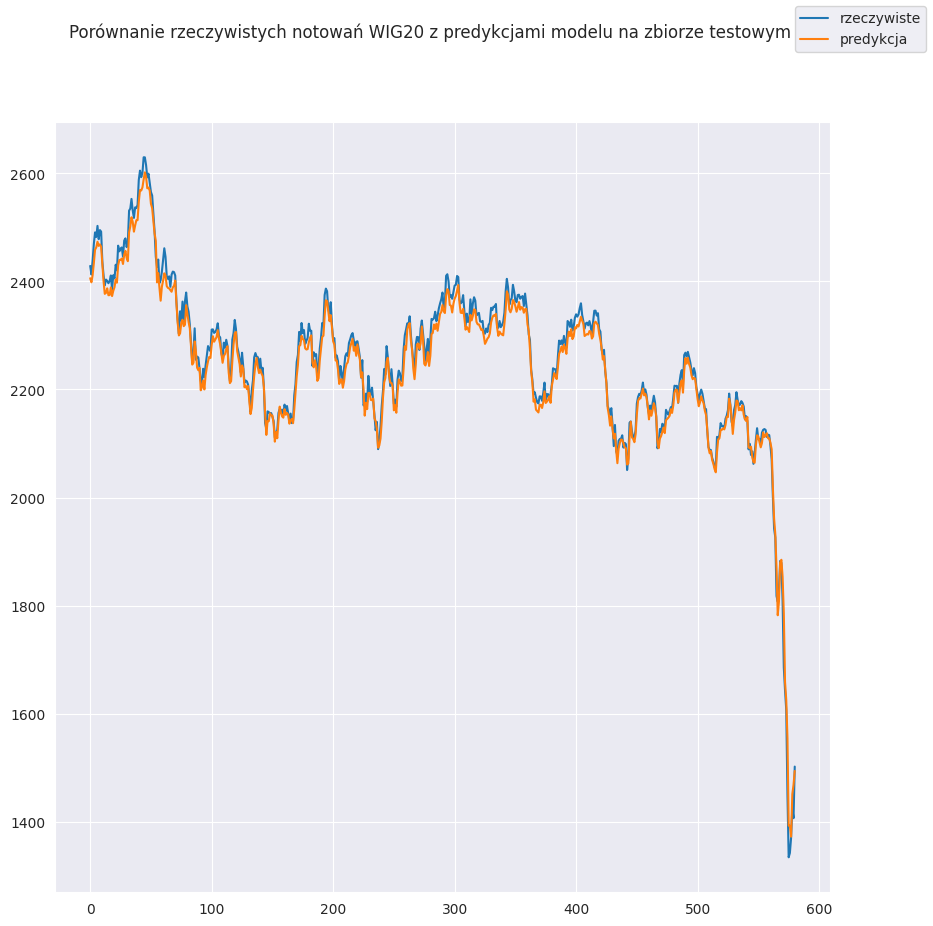

In [29]:
fig = results_plot(y_test, prediction_test, _y_col_num=output_col_num, _prediction_col_num=output_col_num, _scaler=scaler)
fig.suptitle("Porównanie rzeczywistych notowań WIG20 z predykcjami modelu na zbiorze testowym")
fig.savefig("Test_pred.png")
fig.show()


/tmp/ipykernel_5155/90146531.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


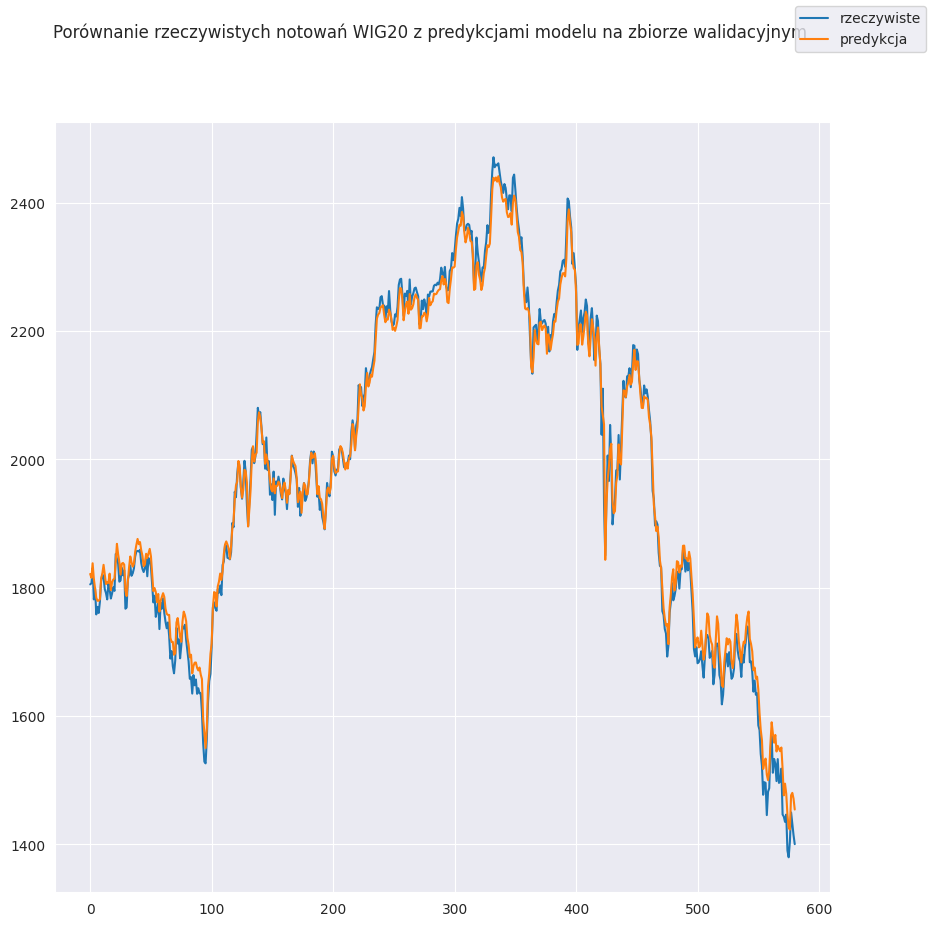

In [30]:
fig = results_plot(y_validation, prediction_validation, _y_col_num=output_col_num, _prediction_col_num=output_col_num, _scaler=scaler)
fig.suptitle("Porównanie rzeczywistych notowań WIG20 z predykcjami modelu na zbiorze walidacyjnym")
fig.savefig("Validation_pred.png")
fig.show()


/tmp/ipykernel_5155/4131342232.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


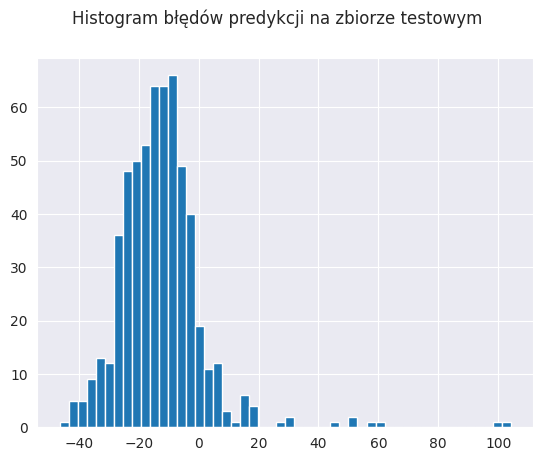

In [31]:
fig = results_histogram(y_test, prediction_test, _y_col_num=output_col_num, _prediction_col_num=output_col_num, _scaler=scaler)
fig.suptitle("Histogram błędów predykcji na zbiorze testowym")
fig.savefig("Test_hist.png")
fig.show()


/tmp/ipykernel_5155/474034046.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


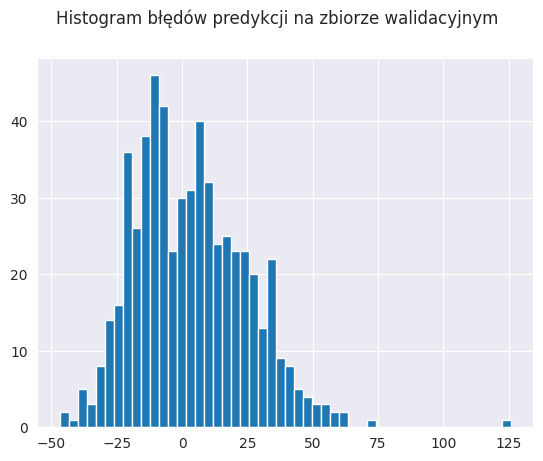

In [32]:
fig = results_histogram(y_validation, prediction_validation, _y_col_num=output_col_num, _prediction_col_num=output_col_num, _scaler=scaler)
fig.suptitle("Histogram błędów predykcji na zbiorze walidacyjnym")
fig.savefig("Validation_hist.png")
fig.show()


In [20]:
#model.save("../Models/tmp")